In [1]:
import numpy as np
import gymnasium as gym
import simple_grid_world
import matplotlib.pyplot as plt
from gymnasium.wrappers import FlattenObservation

from collections import defaultdict

# Make GridWorld Env

In [2]:
### Environment setting ###
env = gym.make(
    'simple_grid_world/GridWorld-v0', 
    render_mode="human", 
#     agent_location=[3,0], 
#     target_location=[[14,3], [5, 23]], 
    target_location=3,
    row=20, col=25, 
    step_reward=-1, 
    term_reward=-1
)
obs, info = env.reset()
obs

(array([12,  7]),
 array([[17,  4],
        [12, 18],
        [ 2, 14]]))

# Build Policy Iteration

In [3]:
class PolicyIteration:
    def __init__(
        self, 
        policy: np.ndarray = np.random.randint(low=0, high=env.action_space.n, size=(env.row, env.col), dtype=int), 
        threshold: float = 30, 
        discount_factor: float = 1.0,
    ):
        self.policy: np.ndarray = policy
        self.threshold: float = threshold
        self.discount_factor: float = discount_factor
        
        self.state_values: np.ndarray = np.zeros(shape=(env.row, env.col), dtype=float)
        
        self.errors: list[float] = []
        
        self._action_to_direction = {
            0: np.array([0, 1]),
            1: np.array([-1, 0]),
            2: np.array([0, -1]),
            3: np.array([1, 0]),
        }
        
    def get_value(self, agent: np.ndarray) -> float:
        return self.state_values[tuple(agent)]
    
    def get_values(self) -> np.ndarray:
        return self.state_values
    
    def get_policy(self) -> np.ndarray:
        return self.policy
    
    def get_action(self, agent: np.ndarray) -> int:
        return self.policy[tuple(agent)]
    
    def check_bound(self, agent, action):
        next_agent, reward = self.step(agent, action)
        return reward != None
        
    def step(self, agent: np.ndarray, action: int) -> (np.ndarray, float):
        next_agent = np.clip(
            agent + self._action_to_direction[action], np.array([0, 0]), np.array([env.row - 1, env.col - 1])
        )
        # 그리드 밖: 무효
        if np.array_equal(next_agent, agent):
            return agent, None
        
        # next_agent가 terminal state인지 체크
        terminated = any(np.array_equal(agent, target) for target in env.init_target)
        reward = env.term_reward if terminated else env.step_reward
        
        return next_agent, reward
        
    def evaluation(self):
        x, y = np.meshgrid(range(env.row), range(env.col))
        agent_space = np.dstack([x, y]).reshape(-1,2)
        while True:
            old_values = self.state_values.copy()
            # state space 전체 돌기
            for agent in agent_space:
                # terminal state check
                terminal = any(np.array_equal(agent, target) for target in env.init_target)
                if terminal:
                    continue
                    
                # deterministic policy
                action = self.get_action(agent)
                self.state_values[tuple(agent)] = self._calc_q(agent, action)
                
            # state space 도는 동안에 가장 큰 에러 갱신
            error = np.max(abs(old_values - self.state_values))
                
            # state space 한 번 돌 때마다 에러 저장
            self.errors.append(error)
            # error가 임계 미만 -> 종료
            if error < self.threshold:
                break
                
    def _calc_q(self, agent: np.ndarray, action: int) -> float:
        next_agent, reward = self.step(agent, action)
        return (
            reward + self.discount_factor * self.get_value(next_agent)
            if self.check_bound(agent, action)  # 그리드 안
            else 0.0
        )
    
    def improvement(self):
        policy_stable = True
        x, y = np.meshgrid(range(env.row), range(env.col))
        agent_space = np.dstack([x, y]).reshape(-1,2)
        for agent in agent_space:
            # terminal state check
            terminal = any(np.array_equal(agent, target) for target in env.init_target)
            if terminal:
                continue
                
            old_action = self.get_action(agent)
            # 모든 액션 돌기
            q_values = np.zeros(env.action_space.n)
            for action in range(env.action_space.n):
                q_values[action] = (
                    self._calc_q(agent, action)
                    if self.check_bound(agent, action)  # 그리드 안
                    else -np.inf
                )
            # greedy policy w.r.t q_values
            self.policy[tuple(agent)] = np.argmax(q_values)
            # greedy update 이루어졌다면
            if old_action != self.get_action(agent):
                policy_stable = False
        if policy_stable:
            return self.get_values(), self.get_policy()
        else:
            return False
    
    def iteration(self):
        self.evaluation()
        while True:
            result = self.improvement()
            if result == False:
                self.evaluation()
            else:
                return result

# Train Policy Iteration

In [12]:
### hyper parameters ###
threshold = 50
discount_factor = 1.0

agent = PolicyIteration(threshold=threshold, discount_factor=discount_factor)

In [13]:
agent.iteration()

(array([[-26., -25., -24., ..., -20., -21., -22.],
        [-25., -24., -23., ..., -19., -20., -21.],
        [-24., -23., -22., ..., -18., -19., -20.],
        ...,
        [-22., -21., -20., ..., -24., -25., -26.],
        [-23., -22., -21., ..., -25., -26., -27.],
        [-24., -23., -22., ..., -26., -27., -28.]]),
 array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]))

# Visualizing training

Text(0.5, 1.0, 'Evaluation Error')

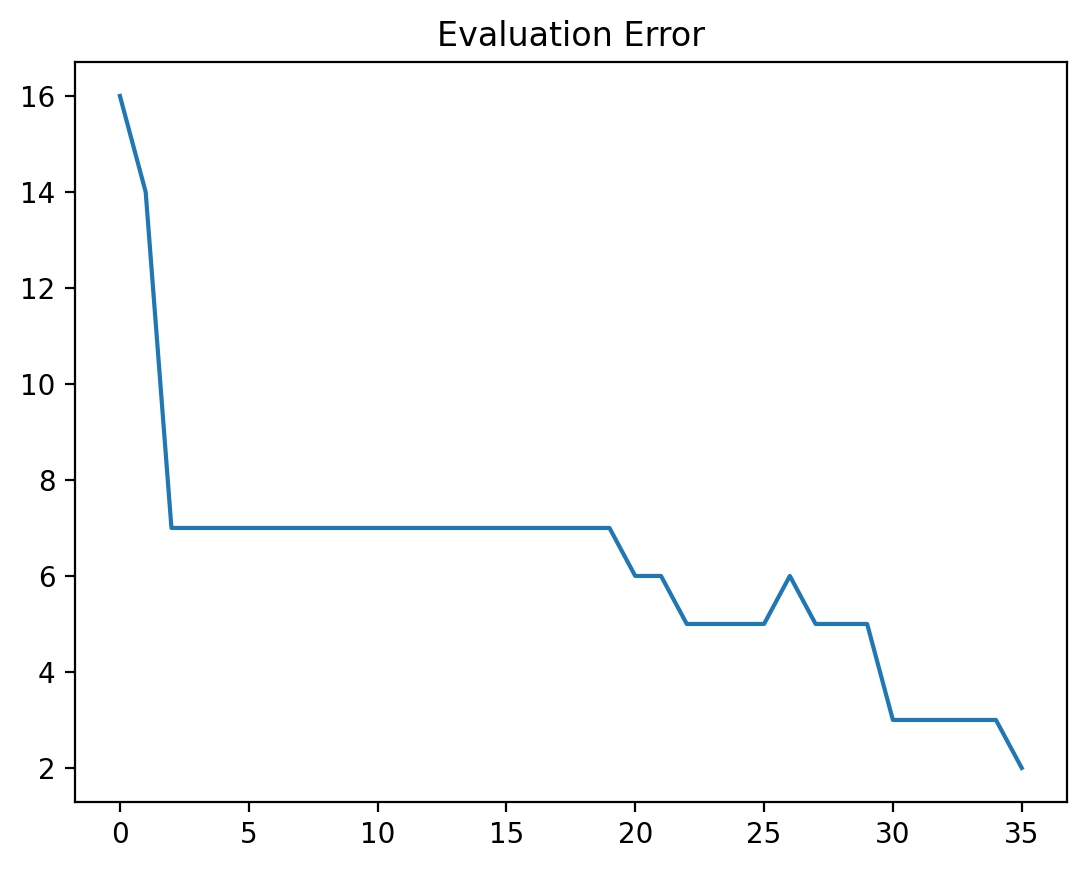

In [14]:
plt.plot(range(len(agent.errors)), agent.errors)
plt.title("Evaluation Error")

# Visualizing play

In [38]:
obs, info = env.reset()
done = False
while not done:
    action = agent.get_action(obs[0])
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    obs = next_obs